# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%.
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%.
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train.

## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [6]:
# Load the required libraries
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader


In [7]:
# Define transforms
from torch.utils.data import random_split
#from torchvision import transformers
 #mean = [0.4914, 0.4822, 0.4465] and std = [0.2023, 0.1994, 0.2010].
transforms_list=transforms.Compose([transforms.RandomCrop(32,padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

# Create training set and define training dataloader
full_train_set=CIFAR10(root='./data',train=True,download=True,transform=transforms_list)

train_size=int(0.8*len(full_train_set))
valid_size=len(full_train_set)-train_size

train_subset,valid_subset=random_split(full_train_set,[train_size,valid_size])
#train_set=CIFAR10(root='./data',train=True,download=True,transform=transforms_list)
train_loader=DataLoader(train_subset,batch_size=16,shuffle=True,num_workers=4)
valid_loader=DataLoader(valid_subset,batch_size=16,shuffle=False,num_workers=4)

# Create test set and define test dataloader

test_set=CIFAR10(root='./data/test',train=False,download=True,transform=transforms_list)
test_loader=DataLoader(test_set,batch_size=16,shuffle=False,num_workers=4)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:10<00:00, 15760096.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 170498071/170498071 [00:10<00:00, 15891359.79it/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


In [8]:
test_set

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/test
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

horse


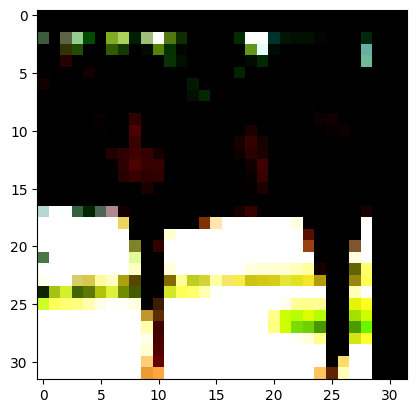

cat


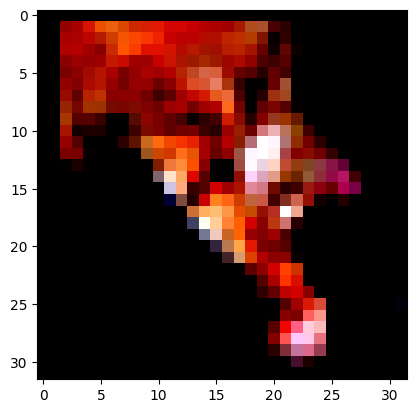

truck


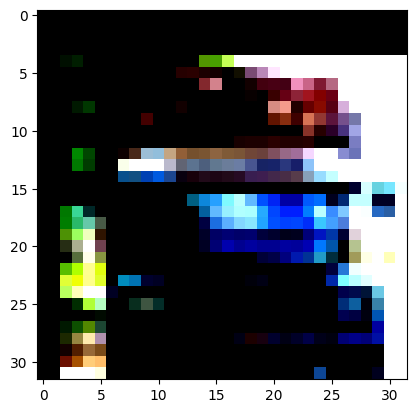

truck


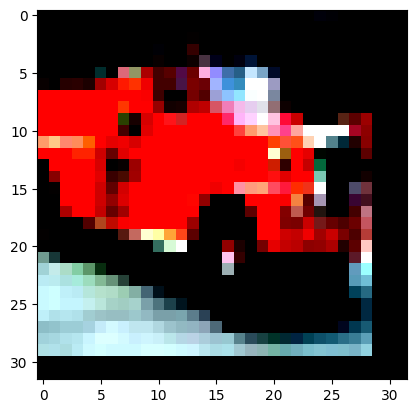

dog


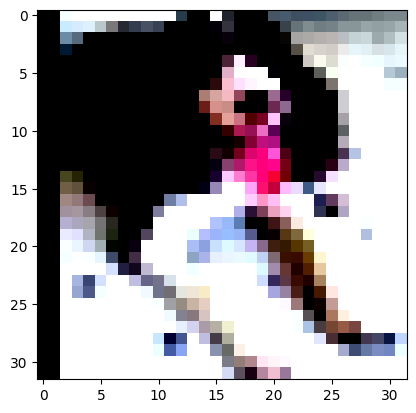

In [10]:
show5(train_loader)

In [11]:
# Explore data
dataiter=iter(full_train_set)
images,labels=next(dataiter)

In [12]:
len(images)

3

In [13]:
images[0].shape

torch.Size([32, 32])

In [14]:
images.shape

torch.Size([3, 32, 32])

In [15]:
labels

6

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [16]:
## YOUR CODE HERE ##
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN,self).__init__()
    #cnn
    self.conv1=nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,padding=1)

    #fully connected layer MLP
    self.fc1=nn.Linear(128*4*4,256)
    self.fc2=nn.Linear(256,10)

    self.dropout=nn.Dropout(0.5)
  def forward(self,x):
    x=F.max_pool2d(F.relu(self.conv1(x)),2)#32*32 => 16*16
    x=F.max_pool2d(F.relu(self.conv2(x)),2)#16*16 => 8*8
    x=F.max_pool2d(F.relu(self.conv3(x)),2)#8*8 => 4*4


    x=x.view(-1,128*4*4)

    x=self.dropout(F.relu(self.fc1(x)))
    x = F.log_softmax(self.fc2(x), dim=1)

    return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
## YOUR CODE HERE ##

In [17]:
num_epoch=10
model=SimpleCNN()
criterion=nn.NLLLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.0)



In [29]:
train_losses=[]
valid_losses=[]
for epoch in range(num_epoch):
  model.train()
  train_loss=0.0
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    train_loss +=loss.item()
  train_losses.append(train_loss/len(train_loader))
  #model evaluation
  model.eval()
  valid_loss=0.0
  with torch.no_grad():
    for input,labels in valid_loader:
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      valid_loss +=loss.item()
    valid_losses.append(valid_loss/len(valid_loader))
    print(f"Epoch {epoch+1}/{num_epoch}, Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {valid_loss/len(valid_loader):.4f}")
    #print(f"Epoch {epoch+1}/{num_epoch} ,Training loss:{train_loss/len(train_loader),Validation loss:{valid_loss/len(valid_loader):.4f}")

Epoch 1/10, Training Loss: 1.9314, Validation Loss: 3.0684
Epoch 2/10, Training Loss: 1.5912, Validation Loss: 3.5338
Epoch 3/10, Training Loss: 1.4498, Validation Loss: 4.3421
Epoch 4/10, Training Loss: 1.3386, Validation Loss: 4.2279
Epoch 5/10, Training Loss: 1.2387, Validation Loss: 4.3312
Epoch 6/10, Training Loss: 1.1511, Validation Loss: 4.6607
Epoch 7/10, Training Loss: 1.0701, Validation Loss: 5.2698
Epoch 8/10, Training Loss: 1.0077, Validation Loss: 4.8804
Epoch 9/10, Training Loss: 0.9586, Validation Loss: 5.2472
Epoch 10/10, Training Loss: 0.9148, Validation Loss: 7.0630


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
## YOUR CODE HERE ##

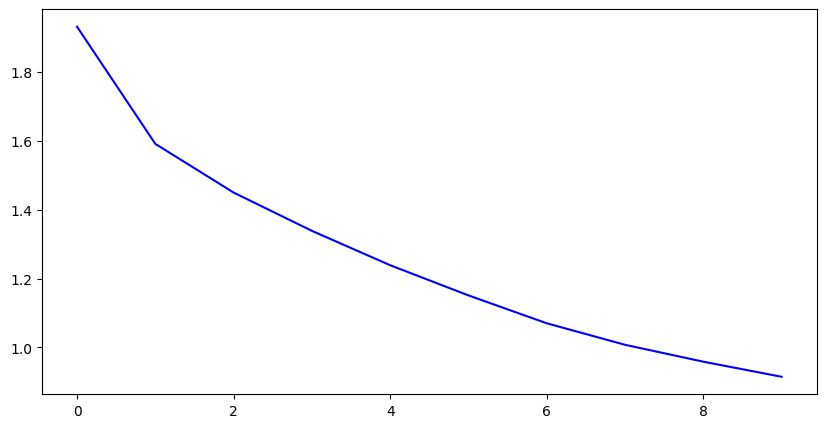

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.show()

Plot the training loss (and validation loss/accuracy, if recorded).

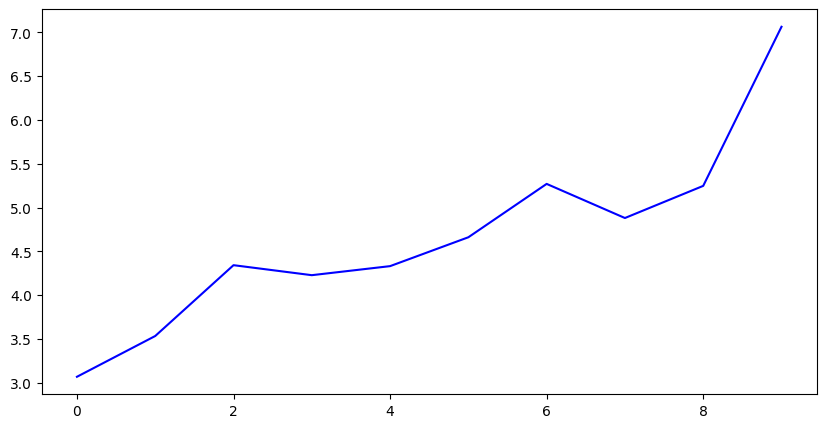

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(valid_losses, label='Validation Loss', color='blue')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 70%, great work!
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [33]:
def compute_accuracy(model, dataloader):
    correct_predictions = 0
    total_predictions = 0

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)

            _, predicted = outputs.max(1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

test_accuracy = compute_accuracy(model, test_loader)

print(f"Accuracy on test set: {test_accuracy:.2f}%")

Accuracy on test set: 70.11%


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
torch.save(model.parameters(),PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature?
* What did you do to get the accuracy you achieved?
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

This model using CNN hits an accuracy of 70Z% which is good. Therefore I would recomend building our own classifier. HOwever, this solutaion still does not beat some of the other models listed in the literature and noted in this project that have accuracies greater then 70%. Here you can also see that the validation error did not decrease consistantly with each additional epoch as did the training. TO impove I would add additional features to the model such as experimenting with different model architectures and also increasing th epoch number.

**Double click this cell to modify it**



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).